In [1]:
# =============================================================================
# NEUROLUNG - TEK MODEL EĞİTİM DOSYASI
# =============================================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# --- 1. AYARLAR VE VERİ İNDİRME ---
print("📂 Kurulum Başlıyor...")
if not os.path.exists('kaggle.json'):
    print("⚠️ Lutfen 'kaggle.json' dosyasini secip yukleyin...")
    files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

if not os.path.exists("covid19-radiography-database.zip"):
    print("⏳ Veri indiriliyor...")
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database
    !unzip -q covid19-radiography-database.zip
    print("✅ Veri İndirme Tamamlandı.")

DATA_PATH = "/content/COVID-19_Radiography_Dataset"
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10  # Kaliteli sonuç için 10 ideal
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Cihaz: {DEVICE}")

# --- 2. VERİ ÖN İŞLEME ---
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=train_transforms)
class_names = full_dataset.classes
print(f"✅ Sınıflar: {class_names}")

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

import copy
test_data.dataset = copy.deepcopy(full_dataset)
test_data.dataset.transform = val_test_transforms
val_data.dataset = copy.deepcopy(full_dataset)
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. EĞİTİM VE RAPORLAMA FONKSİYONLARI ---

def train_model(model, name):
    print(f"\n🔥 {name} Eğitiliyor... (Lütfen Bekleyin)")
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(EPOCHS):
        model.train()
        r_loss, r_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            r_loss += loss.item() * inputs.size(0)
            r_correct += torch.sum(preds == labels.data)

        epoch_loss = r_loss / len(train_data)
        epoch_acc = r_correct.double() / len(train_data) * 100

        model.eval()
        v_loss, v_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                v_loss += criterion(outputs, labels).item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                v_correct += torch.sum(preds == labels.data)

        val_epoch_loss = v_loss / len(val_data)
        val_epoch_acc = v_correct.double() / len(val_data) * 100

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        print(f"Epoch {epoch+1}/{EPOCHS} -> Train Acc: %{epoch_acc:.2f} | Val Acc: %{val_epoch_acc:.2f}")

    # EĞİTİM BİTTİKTEN SONRA OTOMATİK ÇİZDİR VE RAPORLA
    print(f"\n✅ {name} Eğitimi Tamamlandı! Grafikler Çiziliyor...")

    # 1. Grafik
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc', color='blue')
    plt.plot(history['val_acc'], label='Validation Acc', color='orange', linestyle='--')
    plt.title(f'{name} - Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='red')
    plt.plot(history['val_loss'], label='Validation Loss', color='green', linestyle='--')
    plt.title(f'{name} - Loss')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Test Raporu
    print(f"\n🧪 {name} Test Raporu...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

# --- HAZIRLIK BİTTİ, ŞİMDİ MODELİ AŞAĞIDA TANIMLAYIN ---
num_classes = len(class_names)

📂 Kurulum Başlıyor...
⚠️ Lutfen 'kaggle.json' dosyasini secip yukleyin...


Saving kaggle.json to kaggle.json
⏳ Veri indiriliyor...
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 98% 764M/778M [00:07<00:00, 266MB/s]
100% 778M/778M [00:07<00:00, 113MB/s]
✅ Veri İndirme Tamamlandı.
🚀 Cihaz: cuda
✅ Sınıflar: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]



🔥 ResNet50 (Advanced Model) Eğitiliyor... (Lütfen Bekleyin)
Epoch 1/10 -> Train Acc: %76.92 | Val Acc: %79.68
Epoch 2/10 -> Train Acc: %82.02 | Val Acc: %82.66
Epoch 3/10 -> Train Acc: %83.37 | Val Acc: %82.31
Epoch 4/10 -> Train Acc: %84.13 | Val Acc: %84.39
Epoch 5/10 -> Train Acc: %84.82 | Val Acc: %84.36
Epoch 6/10 -> Train Acc: %85.06 | Val Acc: %86.12
Epoch 7/10 -> Train Acc: %85.86 | Val Acc: %84.41
Epoch 8/10 -> Train Acc: %85.85 | Val Acc: %84.27
Epoch 9/10 -> Train Acc: %86.26 | Val Acc: %86.33
Epoch 10/10 -> Train Acc: %86.64 | Val Acc: %86.31

✅ ResNet50 (Advanced Model) Eğitimi Tamamlandı! Grafikler Çiziliyor...


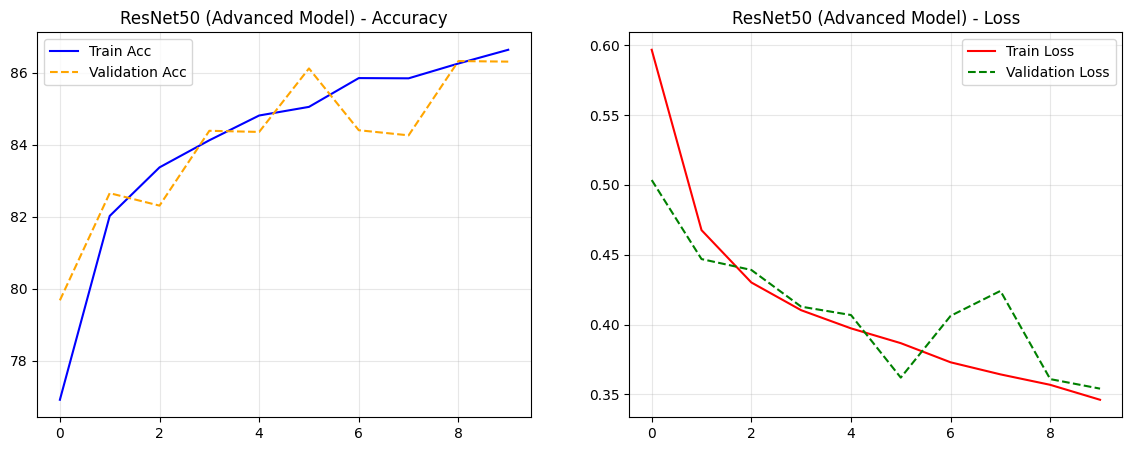


🧪 ResNet50 (Advanced Model) Test Raporu...
                 precision    recall  f1-score   support

          COVID       0.87      0.71      0.78      1106
   Lung_Opacity       0.85      0.83      0.84      1795
         Normal       0.86      0.93      0.89      3039
Viral Pneumonia       0.88      0.93      0.91       411

       accuracy                           0.86      6351
      macro avg       0.87      0.85      0.85      6351
   weighted avg       0.86      0.86      0.86      6351



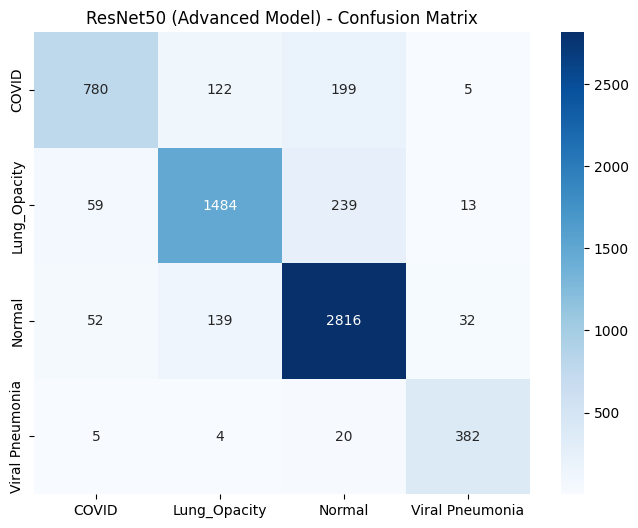

In [2]:
# --- RESNET50 (ADVANCED MODEL) ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# Son katmanı 4 sınıfa göre ayarla
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

# Eğitimi Başlat
train_model(model, "ResNet50 (Advanced Model)")

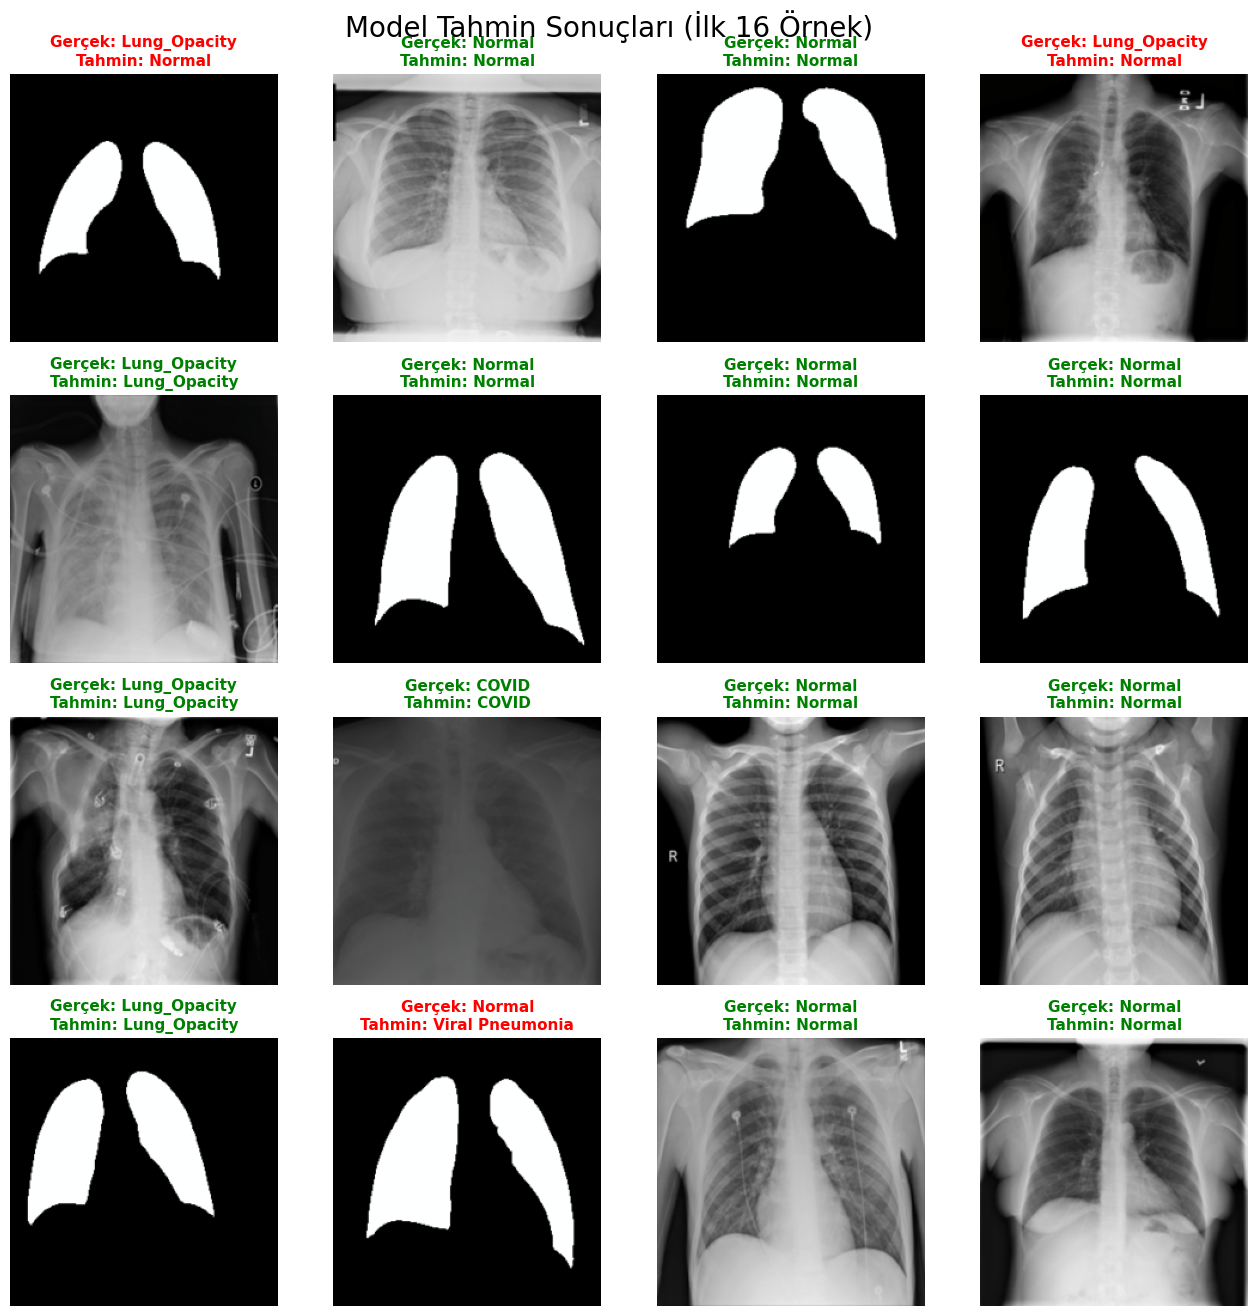

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, loader):
    model.eval()

    # Test setinden bir batch (grup) veri çek
    images, labels = next(iter(loader))
    images = images.to(DEVICE)

    # Tahmin yap
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Görüntülemek için CPU'ya al
    images = images.cpu()

    plt.figure(figsize=(16, 16))

    # İlk 16 resmi çizdir (4x4 ızgara)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)

        # Resmi normale çevir (Un-normalize)
        # Çünkü eğitimde renkleri değiştirmiştik, şimdi eski haline getiriyoruz ki gözle görülsün.
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Renkleri 0-1 arasına sabitle

        plt.imshow(img)

        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]

        # Doğruysa YEŞİL, Yanlışsa KIRMIZI yaz
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color=color, fontsize=11, fontweight='bold')
        plt.axis("off") # Çerçeveleri kaldır

    plt.suptitle("Model Tahmin Sonuçları (İlk 16 Örnek)", fontsize=20, y=0.92)
    plt.show()

# --- ÇALIŞTIRMA KOMUTU ---
# Eğer 'train_model' fonksiyonunu kullandıysan modelin adı 'model' değişkeninde duruyordur.
visualize_predictions(model, test_loader)